In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lung-cancer-preprocessed-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2918858%2F5029682%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240221%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240221T120615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ffef3d27239d941c3c7193598da6964e45a664e6c128e12a0eac9343f532f2c66caf0d1522a00ee9493c2d124e1b0c8a0b1b6c32faaa09d565429015cefb4adf31251271117ddb5fe6ce1c1f5926713dc20dd6bce95ab3711258fdfd3b07ed483bc9a47e0edb050943d34df52bed9ff4bd64eacecfa7aba6ca94759b7fbe8fb1851955a2cb7a160d1378529f82082499dcf69a6849fcc9c636ba86539d7f9bb97fa4b1553dbe421b01a1dd75236ae117a9ac8e49475339fa08f2b52dd01b157fd298555199156f69bcd4f6b6c3b3ccd8223b5ec825670609feea179f25d9267d9798594745ebc0e7661bf2d981f78e1af813e5d2e218a9e480b3e76d49fa05f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 928104510 bytes downloaded
Downloaded and uncompressed: lung-cancer-preprocessed-dataset
Data source import complete.


# Import Libraries and Models

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# Importing TF Data Generator

In [ ]:
train_data= ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip= True,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range= 10
)
train_set=train_data.flow_from_directory(
    "/kaggle/input/lung-cancer-preprocessed-dataset/lung/Train",
    target_size= (224, 224),
    batch_size= 32,
    class_mode= 'sparse'
)


Found 11250 images belonging to 3 classes.


In [ ]:
val_data= ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip= True,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range= 10
)
val_set=train_data.flow_from_directory(
    "/kaggle/input/lung-cancer-preprocessed-dataset/lung/Val",
    target_size= (224, 224),
    batch_size= 32,
    class_mode= 'sparse'
)


Found 1875 images belonging to 3 classes.


In [ ]:

test_data= ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip= True,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range= 10
)
test_set=train_data.flow_from_directory(
    "/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test",
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'sparse'
)


Found 1875 images belonging to 3 classes.


# Checking Image Shape

In [ ]:
for image_batch, label_batch in train_set:
    print(image_batch.shape)
    break

(32, 224, 224, 3)


In [ ]:
class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']
print(class_names)


['adenocarcinoma', 'benign', 'squamous_carcinoma']


In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:


vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:

for layer in vgg.layers:
    layer.trainable = False

In [ ]:

x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)


model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

model.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# Let's Trained The Pretrained Model

In [ ]:
history= model.fit(
  train_set,
  validation_data=val_set,
  epochs=5,
  steps_per_epoch=len(train_set),
  validation_steps=len(val_set)
)

Epoch 1/5
352/352 [==============================] - 206s 559ms/step - loss: 0.1740 - accuracy: 0.9313 - val_loss: 0.1226 - val_accuracy: 0.9563
Epoch 2/5
352/352 [==============================] - 202s 575ms/step - loss: 0.0994 - accuracy: 0.9626 - val_loss: 0.0872 - val_accuracy: 0.9643
Epoch 3/5
352/352 [==============================] - 202s 575ms/step - loss: 0.0777 - accuracy: 0.9697 - val_loss: 0.0941 - val_accuracy: 0.9675
Epoch 4/5
352/352 [==============================] - 185s 525ms/step - loss: 0.0711 - accuracy: 0.9717 - val_loss: 0.0717 - val_accuracy: 0.9723
Epoch 5/5
352/352 [==============================] - 186s 528ms/step - loss: 0.0741 - accuracy: 0.9715 - val_loss: 0.0857 - val_accuracy: 0.9712


# Ploting Loss and Accuracy

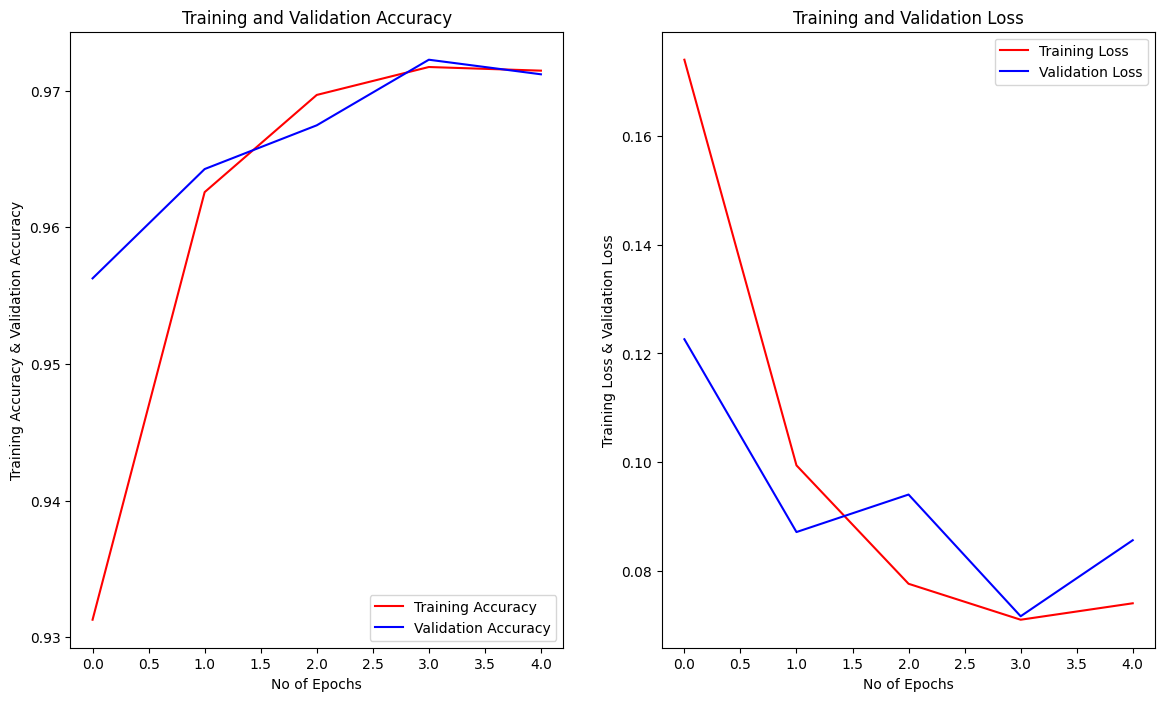

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy',color='red')
plt.plot(range(5), val_acc, label='Validation Accuracy',color='blue')
plt.xlabel('No of Epochs')
plt.ylabel('Training Accuracy & Validation Accuracy')
plt.title('Visualization of Training Accuracy & Validation Accuracy Result')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss',color='red')
plt.plot(range(5), val_loss, label='Validation Loss',color='blue')
plt.xlabel('No of Epochs')
plt.ylabel('Training Loss & Validation Loss')
plt.title('Visualization of Training Loss & Validation Loss Result')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation

In [ ]:
loss,accuracy=model.evaluate(train_set)

352/352 [==============================] - 160s 454ms/step - loss: 0.0538 - accuracy: 0.9817


In [ ]:
accuracy*100

98.1688916683197

In [ ]:
val_loss,val_accuracy=model.evaluate(val_set)
val_accuracy*100

59/59 [==============================] - 28s 470ms/step - loss: 0.0834 - accuracy: 0.9712


97.11999893188477

In [ ]:
test_loss,test_accuracy=model.evaluate(test_set)
test_accuracy*100

59/59 [==============================] - 27s 458ms/step - loss: 0.0800 - accuracy: 0.9739


97.38666415214539

# Prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

first image to predict
actual label: squamous_carcinoma
1/1 [==============================] - 0s 181ms/step
predicted label: squamous_carcinoma


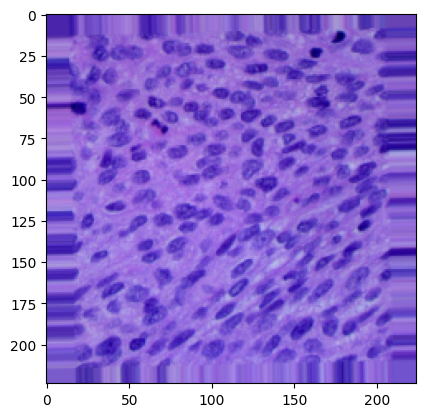

In [ ]:
import numpy as np
for images_batch, labels_batch in test_set:

    first_image = images_batch[0]
    first_label = int(labels_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

1/1 [==============================] - 0s 17ms/step


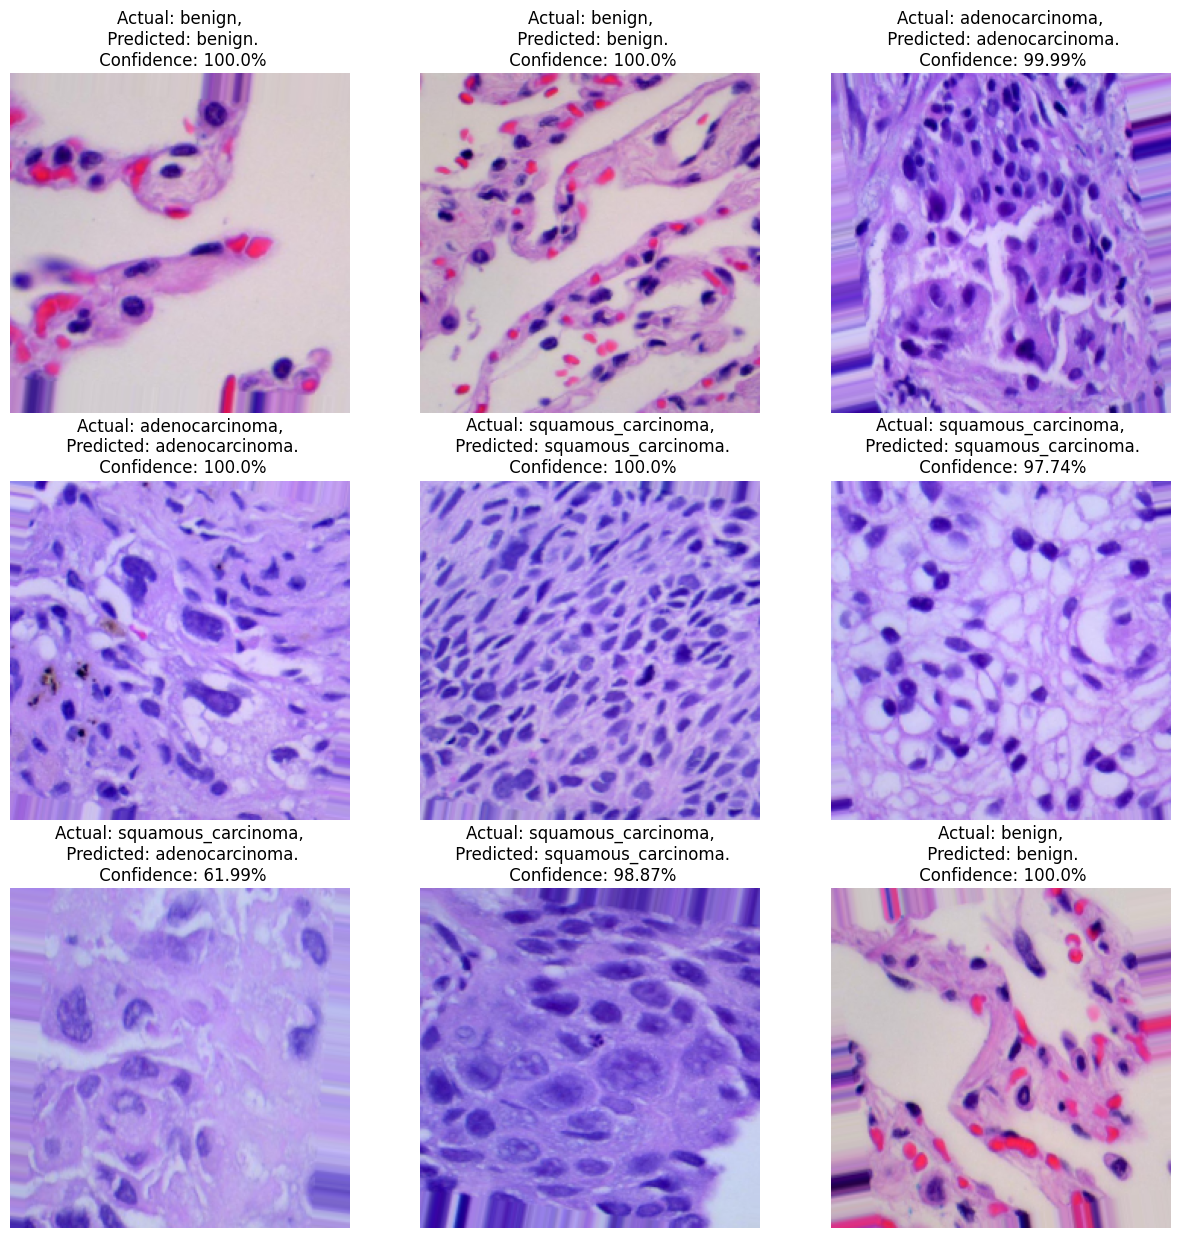

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

Generating predictions...
4/4 [==============================] - 0s 140ms/step
Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.93      0.97      0.95        38
            benign       1.00      1.00      1.00        42
squamous_carcinoma       0.98      0.94      0.96        48

          accuracy                           0.97       128
         macro avg       0.97      0.97      0.97       128
      weighted avg       0.97      0.97      0.97       128

Generating confusion matrix...


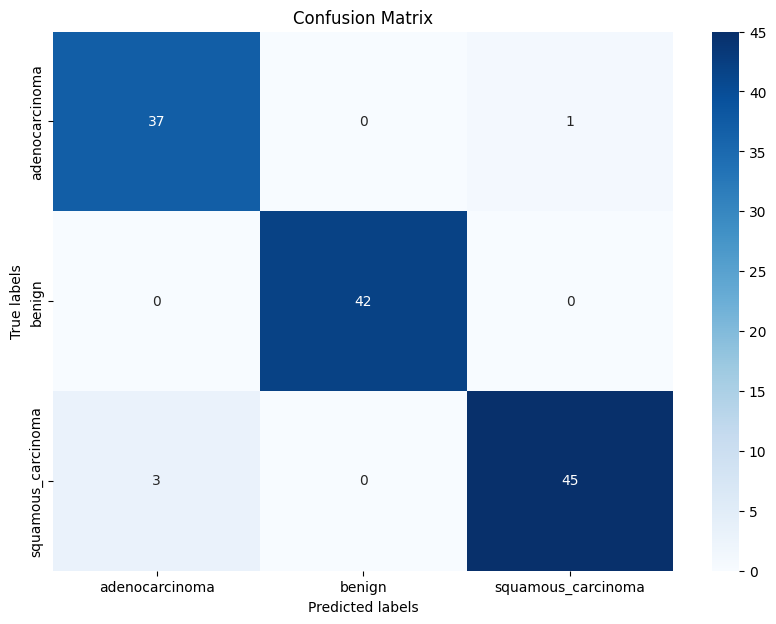

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
subset_size = 100
test_images_subset, test_labels_subset = [], []
for images, labels in test_set:
    if len(test_images_subset) < subset_size:
        test_images_subset.extend(images)
        test_labels_subset.extend(labels)
    else:
        break
test_images_subset = np.array(test_images_subset)
test_labels_subset = np.array(test_labels_subset)

print("Generating predictions...")
y_pred_subset = model.predict(test_images_subset)
y_pred_classes_subset = np.argmax(y_pred_subset, axis=1)

class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']  # Replace with your class names
print("Classification Report:")
print(classification_report(test_labels_subset, y_pred_classes_subset, target_names=class_names))


print("Generating confusion matrix...")
cm_subset = confusion_matrix(test_labels_subset, y_pred_classes_subset)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle
saved_model = pickle.dumps(model)
model.save('my_model.keras')
new_model = tf.keras.models.load_model('my_model.keras')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
model.save('modelname')

Mounted at /gdrive
